# Utils Troubleshooting

Changes to make:
* Write functions to test calculated columns vs. validation
* Test gravity functions, via efficiency

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
pd.set_option('display.max_rows', 1000)

In [36]:
brewersfriend_indices = [330790, 403157]
brewtoad_indices = [258423, 330789]

In [67]:
# How close are we willing to consider a quantity for it to be "ok"?
quality_cutoffs = {
    "og": 0.003,
    "fg": 0.003,
    "abv": 0.05,
    "ibu": 0.05, 
    "color": 0.05
}

In [41]:
def load_recipes(index_range):
    with pd.HDFStore("all_recipes.h5", "r") as store:
        where_clause = f"(index >= {index_range[0]}) & (index <= {index_range[1]})"
        core = store.select("/core", where=where_clause)
        ing = store.select("/ingredients", where=where_clause)
    df = core.join(ing)
    return df

In [78]:
def rename_est_fields(df):
    for col in ["og", "fg", "ibu"]:
        df = df.rename(columns={col: f"est_{col}"})
    return df

In [54]:
def scale_ingreds(df):
    """Add columns for scaled ingredients to the DataFrame"""
    df["ferm_scaled"] = scale_ferm(df, "batch_size")
    df["hop_scaled"] = scale_hop(df, scale_volume_dry="batch_size", scale_volume_boil="batch_size") 
    return df

In [55]:
def calculate_metrics(df):
    """Add columns for the metrics (IBU, SRM, ABV) to the DataFrame"""
    df["pbg"] = gravity_wort(df, scale_volume="boil_size")
    df["og"] = gravity_wort(df, scale_volume="batch_size")  
    df["fg"] = gravity_final(df)
    df["abv"] = abv(df)
    df["color"] = srm(df, ferm_col="ferm_scaled")
    df["ibu"] = ibu(df, hop_col="hop_scaled")
    return df

In [30]:
def quality_measure(col1, col2, cutoff=0.05):
    """
    Col1 is our calculated column (eg. "og")
    Col2 is the test column (eg. "og_est")
    Return a Series of Booleans showing if our calculation is within in the cutoff
    """
    is_field_ok = (abs(col1 - col2)/col2) < cutoff
    return is_field_ok

In [57]:
def add_quality_measures(df):
    for col in ["og", "fg", "abv", "ibu", "color"]:
        df[f"{col}_ok"] = quality_measure(df[col], df[f"est_{col}"], cutoff=quality_cutoffs[col])
    return df

In [84]:
def assess_quality(col1, col2):
    """
    Return measures of how close our calculated field is to the validation one (from the Brewersfriend set).
    
    Col1 is our calculated column 
    Col2 is the test column
    col_type is the string that defines 
    
    % of recipes that are "ok"
    mean difference in percent
    """
    col_ok = quality_measure(col1, col2, cutoff=quality_cutoffs[col1])
    pass

In [69]:
def plot_distribution(col1, col2=pd.DataFrame()):
    """
    Return a matplotlib fig with a nice plot of the distribution of the quantity.
    Optionally, also plot a validation distribution.
    """
    pass

In [79]:
df = load_recipes(brewtoad_indices) 

In [80]:
df = rename_est_fields(df)
df = scale_ingreds(df)

In [81]:
df = calculate_metrics(df)
df = add_quality_measures(df)

In [60]:
df.origin.unique()

array(['brewtoad'], dtype=object)

In [61]:
df.index.nunique()

72367

In [82]:
df.columns

Index(['batch_size', 'boil_size', 'boil_time', 'brewer', 'efficiency',
       'est_abv', 'est_color', 'est_fg', 'est_ibu', 'name', 'est_og', 'origin',
       'recipe_file', 'style_category', 'style_guide', 'style_name',
       'style_version', 'ferm_amount', 'ferm_color', 'ferm_display_amount',
       'ferm_name', 'ferm_origin', 'ferm_potential', 'ferm_yield', 'hop_alpha',
       'hop_amount', 'hop_display_amount', 'hop_form', 'hop_name',
       'hop_origin', 'hop_time', 'hop_use', 'misc_amount',
       'misc_amount_is_weight', 'misc_name', 'misc_time', 'misc_use',
       'yeast_amount', 'yeast_attenuation', 'yeast_flocculation', 'yeast_form',
       'yeast_laboratory', 'yeast_name', 'yeast_product_id', 'yeast_type',
       'ferm_scaled', 'hop_scaled', 'pbg', 'og', 'fg', 'abv', 'color', 'ibu',
       'og_ok', 'fg_ok', 'abv_ok', 'ibu_ok', 'color_ok'],
      dtype='object')

In [73]:
metrics_troubleshoot_cols = ["name", "boil_size", "batch_size", "efficiency", "est_og", "est_fg", "est_abv", "pbg", "og", "fg", "abv", "est_ibu","ibu", "est_color", "color"]

In [74]:
recipe_troubleshoot_cols =["name", "batch_size", "boil_size", "boil_time", "efficiency", "ferm_name", "ferm_amount", "ferm_yield", "ferm_potential"]

In [83]:
df[metrics_troubleshoot_cols + ["og_ok"]]

,name,boil_size,batch_size,efficiency,est_og,est_fg,est_abv,pbg,og,fg,abv,est_ibu,ibu,est_color,color,og_ok
id,,,,,,,,,,,,,,,,
258423,eric's wit,23.658824,18.927059,0.75,NaN,NaN,NaN,1.034652,1.043314,1.010395,4.330294,NaN,29.653943,NaN,3.313667,False
258423,eric's wit,23.658824,18.927059,0.75,NaN,NaN,NaN,1.034652,1.043314,1.010395,4.330294,NaN,29.653943,NaN,3.313667,False
258423,eric's wit,23.658824,18.927059,0.75,NaN,NaN,NaN,1.034652,1.043314,1.010395,4.330294,NaN,29.653943,NaN,3.313667,False
258423,eric's wit,23.658824,18.927059,0.75,NaN,NaN,NaN,1.034652,1.043314,1.010395,4.330294,NaN,29.653943,NaN,3.313667,False
258424,vanilla bourbon imperial stout,5.413139,3.785412,0.75,NaN,NaN,NaN,1.075148,1.107461,1.029015,10.132476,NaN,324.335376,NaN,79.251900,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330789,half-hearted ale (quick- harvest)2,23.658824,18.927059,0.75,NaN,NaN,NaN,1.039433,1.049291,1.012323,4.853738,NaN,121.264066,NaN,6.735054,False
330789,half-hearted ale (quick- harvest)2,23.658824,18.927059,0.75,NaN,NaN,NaN,1.039433,1.049291,1.012323,4.853738,NaN,121.264066,NaN,6.735054,False
330789,half-hearted ale (quick- harvest)2,23.658824,18.927059,0.75,NaN,NaN,NaN,1.039433,1.049291,1.012323,4.853738,NaN,121.264066,NaN,6.735054,False


## OG and ABV

In [19]:
def count_true(gb):
    d = {
        "ok": gb.sum(),
    }
    return pd.Series(d)

In [20]:
def count_false(gb):
    d = {
        "not_ok": len(gb) - gb.sum(),
    }
    return pd.Series(d)

In [21]:
df.columns

Index(['batch_size', 'boil_size', 'boil_time', 'brewer', 'efficiency',
       'est_abv', 'est_color', 'est_fg', 'est_ibu', 'name', 'est_og', 'origin',
       'recipe_file', 'style_category', 'style_guide', 'style_name',
       'style_version', 'ferm_amount', 'ferm_color', 'ferm_display_amount',
       'ferm_name', 'ferm_origin', 'ferm_potential', 'ferm_yield', 'hop_alpha',
       'hop_amount', 'hop_display_amount', 'hop_form', 'hop_name',
       'hop_origin', 'hop_time', 'hop_use', 'misc_amount',
       'misc_amount_is_weight', 'misc_name', 'misc_time', 'misc_use',
       'yeast_amount', 'yeast_attenuation', 'yeast_flocculation', 'yeast_form',
       'yeast_laboratory', 'yeast_name', 'yeast_product_id', 'yeast_type',
       'hop_scaled_boil', 'hop_scaled_batch', 'ferm_scaled_boil',
       'ferm_scaled_batch', 'ferm_scaled', 'pbg', 'og', 'fg', 'color', 'ibu',
       'abv', 'og_ok', 'fg_ok', 'ibu_ok', 'abv_ok', 'color_ok'],
      dtype='object')

In [22]:
metric_to_test = "abv"
ok_cols = ["og_ok", "fg_ok", "abv_ok"]
ok_counts = df.groupby(["efficiency"])[ok_cols].agg({"ok": count_true, "not_ok": count_false})

/Users/rwelch/code_home/beer.ai/env/lib/python3.8/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [23]:
ok_counts

ok              not_ok             
           og_ok fg_ok abv_ok  og_ok fg_ok abv_ok
efficiency                                       
0.0000         0     0      0     27    27     27
0.0100         0     0      0      4     4      4
0.0500         0     0      0     11    11     11
0.0660         5     5      0      0     0      5
0.1000         0     1      0     12    11     12
0.1500         0     0      0      6     6      6
0.2000         0     0      0      6     6      6
0.2200         0     0      0      6     6      6
0.2300         0     0      0      4     4      4
0.2500         2     2      0     90    90     92
0.3000         0     0      0     55    55     55
0.3200         4     4      4      0     0      0
0.3300         3     3      3      0     0      0
0.3500       170   244    126   2205  2131   2249
0.4000         0     0      0     38    38     38
0.4200         7    14      7      7     0      7
0.4450         8     8      8      0     0      0
0.4500        13    29     22     35    19     26
0.4700         7     7      7     11    11     11
0.4900         8     8      8      0     0      0
0.5000       144   176    129    170   138    185
0.5100        14    14     14      0     0      0
0.5200         0     5      5      5     0      0
0.5240         3     3      3      0     0      0
0.5300        11    18      4      7     0     14
0.5400        18    25     12      7     0     13
0.5450         0     0      0      6     6      6
0.5500       121   130     97     13     4     37
0.5550         9     9      9      0     0      0
0.5600        25    25     19      4     4     10
0.5700        25    25     18      0     0      7
0.5750         7     7      0      0     0      7
0.5800        74    68     68      0     6      6
0.5850        11    11      0      0     0     11
0.5880         4     4      4      0     0      0
0.5900        19    22     18      3     0      4
0.6000       871   947    805    196   120    262
0.6100        76    68     68      4    12     12
0.6120         9     9      9      0     0      0
0.6200       176   206    180     30     0     26
0.6250        12    12     12      0     0      0
0.6300       171   176    145     31    26     57
0.6350         9     9      9      0     0      0
0.6400        66    62     54      6    10     18
0.6500      1560  1674   1483    311   197    388
0.6600        95    86     82      0     9     13
0.6700       204   233    201     39    10     42
0.6710         4     4      4      0     0      0
0.6800       421   431    415     51    41     57
0.6850         4     4      4      0     0      0
0.6867         4     4      4      0     0      0
0.6900       132   132    109     20    20     43
0.7000      5860  6392   5426   1090   558   1524
0.7050         4     4      0      0     0      4
0.7100       183   187    145     10     6     48
0.7130         0     5      5      5     0      0
0.7200       764   769    672     84    79    176
0.7250        21    21     21      0     0      0
0.7300       357   376    328     50    31     79
0.7400       200   213    196     19     6     23
0.7500      3710  4171   3577    742   281    875
0.7600       124   134    109     10     0     25
0.7650         4     4      0      0     0      4
0.7700       201   203    167     10     8     44
0.7781         5     5      5      0     0      0
0.7800       370   389    337     48    29     81
0.7820         4     4      4      0     0      0
0.7900        81    85     79     15    11     17
0.8000      1112  1148    980    107    71    239
0.8010         0     5      5      5     0      0
0.8100        35    42     39      7     0      3
0.8200       107    90     92     16    33     31
0.8210         6     6      6      0     0      0
0.8300        51    73     73     22     0      0
0.8400        51    63     50     17     5     18
0.8500       323   362    318     44     5     49
0.8510         5     5      5      0     0      0
0.8600        

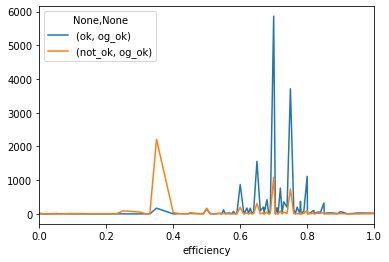

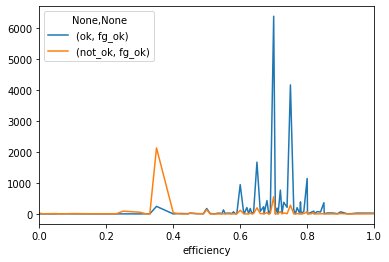

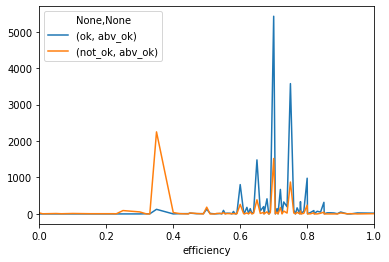

In [258]:
for col in ok_cols:
    ok_counts[[("ok",col), ("not_ok", col)]].plot()